# FAST-EM import
---
**Author**: Ryan Lane  
**Date**: 6 April 2022

#### Overview
Quickly imports a FAST-EM project to `render-ws`.

Assumes data is stored as

Stack | Filepath
- | -
raw | `/.../asm_service/{date}/{project}/{section}/{row}_{col}_{zoom}.tiff`
corrected | `/.../asm_service/{date}/{stack}/{section}/corrected/{row}_{col}_{zoom}.tiff`

and outputs mipmaps of each field's pyramidal tiff to

Stack | Filepath
- | -
raw | `/.../{project}/raw/{section}/{row}_{col}/{zoom}.tif`
corrected | `/.../{project}/corrected/{section}/{row}_{col}/{zoom}.tif`

**Warning**:
Check filepath tree carefully before executing.

In [1]:
from pathlib import Path
import re
from ruamel.yaml import YAML

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup as Soup
import numpy as np
import pandas as pd
from tifffile import TiffFile

import renderapi
import icatapi
import fastemworkflow
from renderapi.transform import AffineModel

In [2]:
# Indirectly enable autocomplete
%config Completer.use_jedi = False

# pandas display options
pd.set_option('display.max_colwidth', 20)

#### Connect to `render-ws`

In [3]:
# render parameters
owner = 'akievits'
date = '2022-06-10'
project = '20220610_UMCU'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G',
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'akievits',
 'project': '20220610_UMCU',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Import and export directories

In [4]:
# Import from
dir_FASTEM = Path(f'/long_term_storage/asm_storage/asm_service/{date}/{project}')
# Export to
dir_project = Path(f"/long_term_storage/{owner}/FAST-EM/{project}/")

# Stack directory
!ls -l $dir_FASTEM

total 16
drwxrwxrwx 3 asmftp asmftp 4096 Jun 10 11:31 EPON_80nm_s001
drwxrwxrwx 3 asmftp asmftp 4096 Jun 10 14:51 EPON_80nm_s002


#### Section mapping

In [5]:
# Assume subdirectories of FAST-EM directories are different sections (durr)
dir_sections = sorted([dir_ for dir_ in dir_FASTEM.iterdir() if dir_.is_dir()])
d_sections = {i: d.name for i, d in enumerate(dir_sections)}
d_sections

{0: 'EPON_80nm_s001', 1: 'EPON_80nm_s002'}

## 1) Create mipmaps
---

#### Filepath layout
Mimaps of each FAST-EM field are output to
`{dir_project}/{stack}/{sectionId}/{row}_{col}/{zoom}.tif` e.g.

In [6]:
from fastemworkflow.importdata import create_mipmaps
from fastemworkflow.importdata import generate_mipmaps_from_sections

In [24]:
dir_sections

[PosixPath('/long_term_storage/asm_storage/asm_service/2022-06-10/20220610_UMCU/EPON_80nm_s001'),
 PosixPath('/long_term_storage/asm_storage/asm_service/2022-06-10/20220610_UMCU/EPON_80nm_s002')]

#### Raw

In [7]:
# Generate mipmaps from 'raw' stack for every section
generate_mipmaps_from_sections(dir_sections, 
                               stack_name='raw')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

#### Corrected

In [8]:
# Generate mipmaps from 'corrected' stack for every section
generate_mipmaps_from_sections(dir_sections, 
                               stack_name='corrected')  

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

## 2) Create tile specifications
---

#### Filepath layout
Reminder that mimaps of each FAST-EM field are output to
`{dir_project}/{stack}/{sectionId}/{row}_{col}/{zoom}.tif`

In [9]:
import json
from renderapi.image_pyramid import ImagePyramid, MipMapLevel

In [10]:
# Parameters
overlap = 10  # % -- guess

# Collect tile specifications
tile_dicts = []
# Loop through stack directories
for dir_stack in tqdm(list(dir_project.iterdir())):
    # Set stack name ('raw' or 'corrected')
    stack = dir_stack.name

    # Loop through section directories
    for z, sectionId in tqdm(d_sections.items()):

        # Loop through mipmap directories within each section
        dir_section = dir_stack / sectionId
        for dir_mipmap in tqdm(list(dir_section.glob('[0-9]*_[0-9]*')),
                               leave=False):

            # Read base-level tiff
            fp = dir_mipmap / '0.tif'
            tiff = TiffFile(fp)
            # Parse tiff tags for metadata
            md = json.loads(tiff.pages[0].description)
            # Infer row, col
            row, col = [int(i) for i in re.findall(r'\d+', fp.parent.name)[:2]]
            # Set translation based on overlap guess
            x0 = col * (1 - overlap/100) * md['ImageWidth']
            y0 = row * (1 - overlap/100) * md['ImageLength']

            # Create nested MipMapLevels
            mmls = []
            for mmfp in sorted(dir_mipmap.glob('[0-9].tif')):
                level = mmfp.stem
                imageUrl = f"https://sonic.tnw.tudelft.nl{mmfp.as_posix()}"
                mml = MipMapLevel(level, imageUrl=imageUrl)
                mmls.append(mml)
            # Create ImagePyramid from MipMapLevels
            ip = ImagePyramid({m.level: m.mipmap for m in mmls})

            # Handle missing DateTime metadata in corrected tiffs
            try:
                acqtime = pd.to_datetime(md['DateTime'])
            except KeyError:
                acqtime = -1

            # Build up tile specification
            ts = {}
            ts['stack'] = stack
            ts['sectionId'] = sectionId
            ts['z'] = z
            ts['tileId'] = f'{stack[:3]}-S{z:03d}-{row:03d}x{col:03d}'
            ts['acqtime'] = acqtime
            ts['width'] = md['ImageWidth']
            ts['height'] = md['ImageLength']
            ts['imageRow'] = row
            ts['imageCol'] = col
            ts['imagePyramid'] = ip
            ts['minint'] = 0
            ts['maxint'] = 65535
            ts['tforms'] = [AffineModel(B0=x0, B1=y0)]
            tile_dicts.append(ts)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

#### Create stack DataFrames

In [11]:
# Create DataFrame from list of tile specifications
df_stacks = pd.DataFrame(tile_dicts)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(3))

stack       sectionId  z            tileId  \
stack                                                           
corrected 267  corrected  EPON_80nm_s001  0  cor-S000-002x003   
          377  corrected  EPON_80nm_s002  1  cor-S001-001x003   
          319  corrected  EPON_80nm_s001  0  cor-S000-007x000   
raw       99         raw  EPON_80nm_s001  0  raw-S000-009x000   
          48         raw  EPON_80nm_s001  0  raw-S000-004x004   
          207        raw  EPON_80nm_s002  1  raw-S001-007x009   

                           acqtime  width  height  imageRow  imageCol  \
stack                                                                   
corrected 267                   -1   6400    6400         2         3   
          377                   -1   6400    6400         1         3   
          319                   -1   6400    6400         7         0   
raw       99   2022-06-10 09:20:00   6400    6400         9         0   
          48   2022-06-10 09:12:16   6400    6400         4         4   
          207  2022-06-10 12:33:49   6400    6400         7         9   

                  imagePyramid  minint  maxint               tforms  
stack                                                                
corrected 267  [0, 1, 2, 3, 4]       0   65535  [M=[[1.000000,0....  
          377  [0, 1, 2, 3, 4]       0   65535  [M=[[1.000000,0....  
          319  [0, 1, 2, 3, 4]       0   65535  [M=[[1.000000,0....  
raw       99      [0, 1, 2, 3]       0   65535  [M=[[1.000000,0....  
          48      [0, 1, 2, 3]       0   65535  [M=[[1.000000,0....  
          207     [0, 1, 2, 3]       0   65535  [M=[[1.000000,0....

### Set intensity levels
Sample `n` images/section to determine reasonable min/max intensity values.

In [12]:
# Set parameters
n = 10          # sample size (per section)
pcts = (1, 99)  # % for intensity clipping
stacks = df_stacks['stack'].unique().tolist()
z_values = df_stacks['z'].unique().tolist()

# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack'),
                            total=len(stacks)):

    # Loop through sections
    for z, tileset in tqdm(df_stack.groupby('z'),
                           total=len(z_values),
                           leave=False):

        # Sample filepaths
        fps = tileset.sample(n)['imagePyramid']\
                      .apply(lambda x: x[0]['imageUrl'])\
                      .tolist()

        # Collect min/max intensity values
        minints = []
        maxints = []
        # Loop through sample tiles
        for fp in tqdm(fps, leave=False):

            # Load tiff image
            fp_tiff = fp.split('.nl')[1]
            tiff = TiffFile(fp_tiff)
            image = tiff.asarray()

            # Get intensity percentiles
            minint, maxint = np.percentile(image, pcts)
            minints.append(minint)
            maxints.append(maxint)

        # Set min/max intensity
        df_stacks.loc[(df_stacks['stack'] == stack) &\
                      (df_stacks['z'] == z), 'minint'] = np.mean(minints, dtype=int)
        df_stacks.loc[(df_stacks['stack'] == stack) &\
                      (df_stacks['z'] == z), 'maxint'] = np.mean(maxints, dtype=int)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(4))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

stack       sectionId  z            tileId  \
stack                                                           
corrected 459  corrected  EPON_80nm_s002  1  cor-S001-008x008   
          351  corrected  EPON_80nm_s001  0  cor-S000-009x010   
          359  corrected  EPON_80nm_s001  0  cor-S000-010x007   
          430  corrected  EPON_80nm_s002  1  cor-S001-006x001   
raw       1          raw  EPON_80nm_s001  0  raw-S000-000x001   
          173        raw  EPON_80nm_s002  1  raw-S001-004x008   
          209        raw  EPON_80nm_s002  1  raw-S001-008x000   
          228        raw  EPON_80nm_s002  1  raw-S001-009x008   

                           acqtime  width  height  imageRow  imageCol  \
stack                                                                   
corrected 459                   -1   6400    6400         8         8   
          351                   -1   6400    6400         9        10   
          359                   -1   6400    6400        10         7   
          430                   -1   6400    6400         6         1   
raw       1    2022-06-10 09:05:10   6400    6400         0         1   
          173  2022-06-10 12:24:14   6400    6400         4         8   
          209  2022-06-10 12:34:23   6400    6400         8         0   
          228  2022-06-10 12:39:45   6400    6400         9         8   

                  imagePyramid  minint  maxint               tforms  
stack                                                                
corrected 459  [0, 1, 2, 3, 4]   29630   35117  [M=[[1.000000,0....  
          351  [0, 1, 2, 3, 4]   29950   35620  [M=[[1.000000,0....  
          359  [0, 1, 2, 3, 4]   29950   35620  [M=[[1.000000,0....  
          430  [0, 1, 2, 3, 4]   29630   35117  [M=[[1.000000,0....  
raw       1       [0, 1, 2, 3]   50901   57016  [M=[[1.000000,0....  
          173     [0, 1, 2, 3]   47365   55644  [M=[[1.000000,0....  
          209     [0, 1, 2, 3]   47365   55644  [M=[[1.000000,0....  
          228     [0, 1, 2, 3]   47365   55644  [M=[[1.000000,0....

## 3) Upload stack to `render-ws`
---

In [16]:
from renderapi.render import get_stacks_by_owner_project
from renderapi.tilespec import TileSpec, get_tile_specs_from_stack
from renderapi.stack import create_stack, set_stack_state
from renderapi.client import import_tilespecs

In [17]:
from icatapi.render_pandas import upload_stack_DataFrame

In [18]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = 4
    Ry = 4
    Rz = 100

    # Create stacks
    upload_stack_DataFrame(df=df_stack,
                           name=stack,
                           stackResolutionX=Rx,
                           stackResolutionY=Ry,
                           stackResolutionZ=Rz,
                           render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for corrected...
Importing tile specifications to corrected...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://sonic.tnw.tudelft.nl:8080/render-ws/v1 --owner akievits --project 20220610_UMCU --stack corrected /tmp/tmpdjaa03ac.json


12:12:43.006 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
12:12:43.161 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://sonic.tnw.tudelft.nl:8080/render-ws/v1",
    "owner" : "akievits",
    "project" : "20220610_UMCU"
  },
  "tileSpecValidator" : { },
  "stack" : "corrected",
  "tileFiles" : [
    "/tmp/tmpdjaa03ac.json"
  ]
}
12:12:43.928 [main]

#### Inspect

  0%|          | 0/2 [00:00<?, ?it/s]

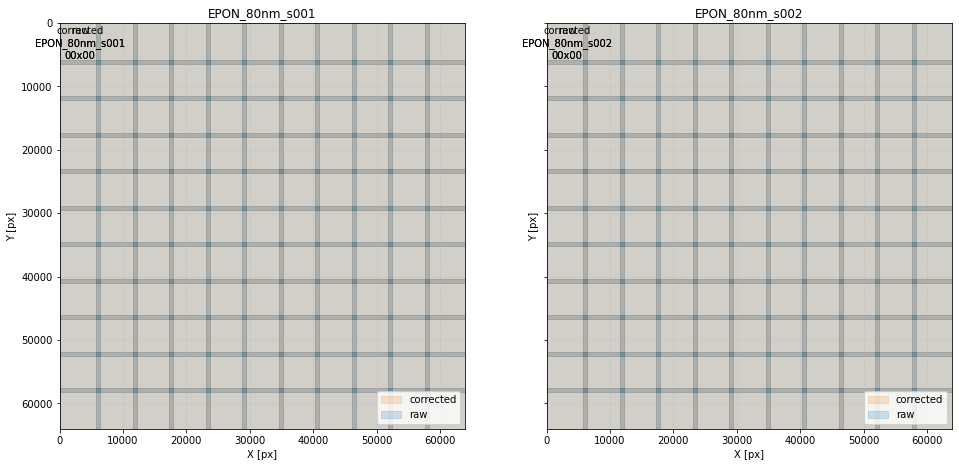

In [19]:
icatapi.plot_tile_map(stacks,
                      render=render)

## 4) Montage
---

Parse transformation data from `.../corrected/montage.xml` file.

In [20]:
# Initialize stacks DataFrame
df_stacks = pd.DataFrame()

# Loop through stacks
for stack in tqdm(stacks):

    # Create stack DataFrame
    df_stack = icatapi.create_stack_DataFrame(stack=stack,
                                              render=render)
    # Edit stack name
    df_stack['stack'] = stack + '_montaged'

    # Loop through section directories
    for z, dir_section in enumerate(dir_sections):

        # Parse montage.xml file
        fp = dir_section / 'corrected/montage.xml'
        soup = Soup(fp.read_text(), 'lxml')

        # Loop through "patches"
        for patch in soup.find_all('t2_patch'):

            # Parse transform data
            M00, M10, M01, M11, B0, B1 = [float(i) for i in re.findall(
                r'-?[\d.]+(?:[Ee]-?\d+)?', patch['transform'])]
            A = AffineModel(M00, M01, M10, M11, B0, B1)

            # Infer stack index
            row, col = [int(i) for i in patch['title'].split('_')[:2]]
            i = df_stack.loc[(df_stack['z'] == z) &\
                             (df_stack['imageRow'] == row) &\
                             (df_stack['imageCol'] == col)].index.item()
            df_stack.at[i, 'tforms'] = [A]

    # 
    df_stacks = pd.concat([df_stacks, df_stack])

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(4))

  0%|          | 0/2 [00:00<?, ?it/s]

/home/akievits/miniconda3/envs/fastem/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
/home/akievits/miniconda3/envs/fastem/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argumen

tileId    z   width  height   minint  \
stack                                                                    
corrected_montaged 81   cor-S000-007x004  0.0  6400.0  6400.0  29950.0   
                   89   cor-S000-008x001  0.0  6400.0  6400.0  29950.0   
                   90   cor-S000-008x002  0.0  6400.0  6400.0  29950.0   
                   219  cor-S001-008x010  1.0  6400.0  6400.0  29630.0   
raw_montaged       210  raw-S001-008x001  1.0  6400.0  6400.0  47365.0   
                   141  raw-S001-001x009  1.0  6400.0  6400.0  47365.0   
                   12   raw-S000-001x001  0.0  6400.0  6400.0  50901.0   
                   84   raw-S000-007x007  0.0  6400.0  6400.0  50901.0   

                         maxint     imagePyramid               tforms  \
stack                                                                   
corrected_montaged 81   35620.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   89   35620.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   90   35620.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   219  35117.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
raw_montaged       210  55644.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   141  55644.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   12   57016.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   84   57016.0     [0, 1, 2, 3]  [M=[[1.000000,0....   

                                     stack       sectionId  imageRow  imageCol  
stack                                                                           
corrected_montaged 81   corrected_montaged  EPON_80nm_s001         7         4  
                   89   corrected_montaged  EPON_80nm_s001         8         1  
                   90   corrected_montaged  EPON_80nm_s001         8         2  
                   219  corrected_montaged  EPON_80nm_s002         8        10  
raw_montaged       210        raw_montaged  EPON_80nm_s002         8         1  
                   141        raw_montaged  EPON_80nm_s002         1         9  
                   12         raw_montaged  EPON_80nm_s001         1         1  
                   84         raw_montaged  EPON_80nm_s001         7         7

#### Upload montage stacks

In [21]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = 4
    Ry = 4
    Rz = 100

    # Create stacks
    upload_stack_DataFrame(df=df_stack,
                           name=stack,
                           stackResolutionX=Rx,
                           stackResolutionY=Ry,
                           stackResolutionZ=Rz,
                           render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for corrected_montaged...
Importing tile specifications to corrected_montaged...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://sonic.tnw.tudelft.nl:8080/render-ws/v1 --owner akievits --project 20220610_UMCU --stack corrected_montaged /tmp/tmp4d2z31w3.json


12:12:48.943 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
12:12:49.103 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://sonic.tnw.tudelft.nl:8080/render-ws/v1",
    "owner" : "akievits",
    "project" : "20220610_UMCU"
  },
  "tileSpecValidator" : { },
  "stack" : "corrected_montaged",
  "tileFiles" : [
    "/tmp/tmp4d2z

#### Inspect

  0%|          | 0/2 [00:00<?, ?it/s]

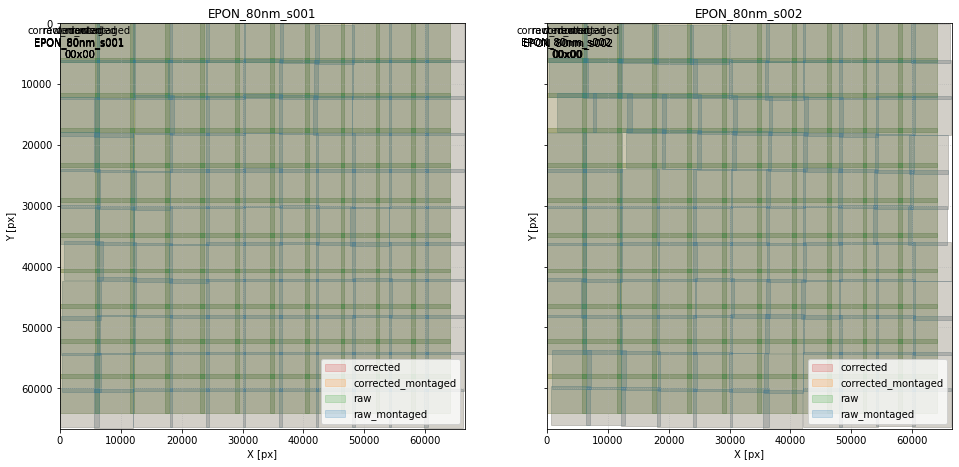

In [22]:
stacks_2_plot = renderapi.render.get_stacks_by_owner_project(render=render)
icatapi.plot_tile_map(stacks_2_plot,
                      render=render)

  0%|          | 0/8 [00:00<?, ?it/s]

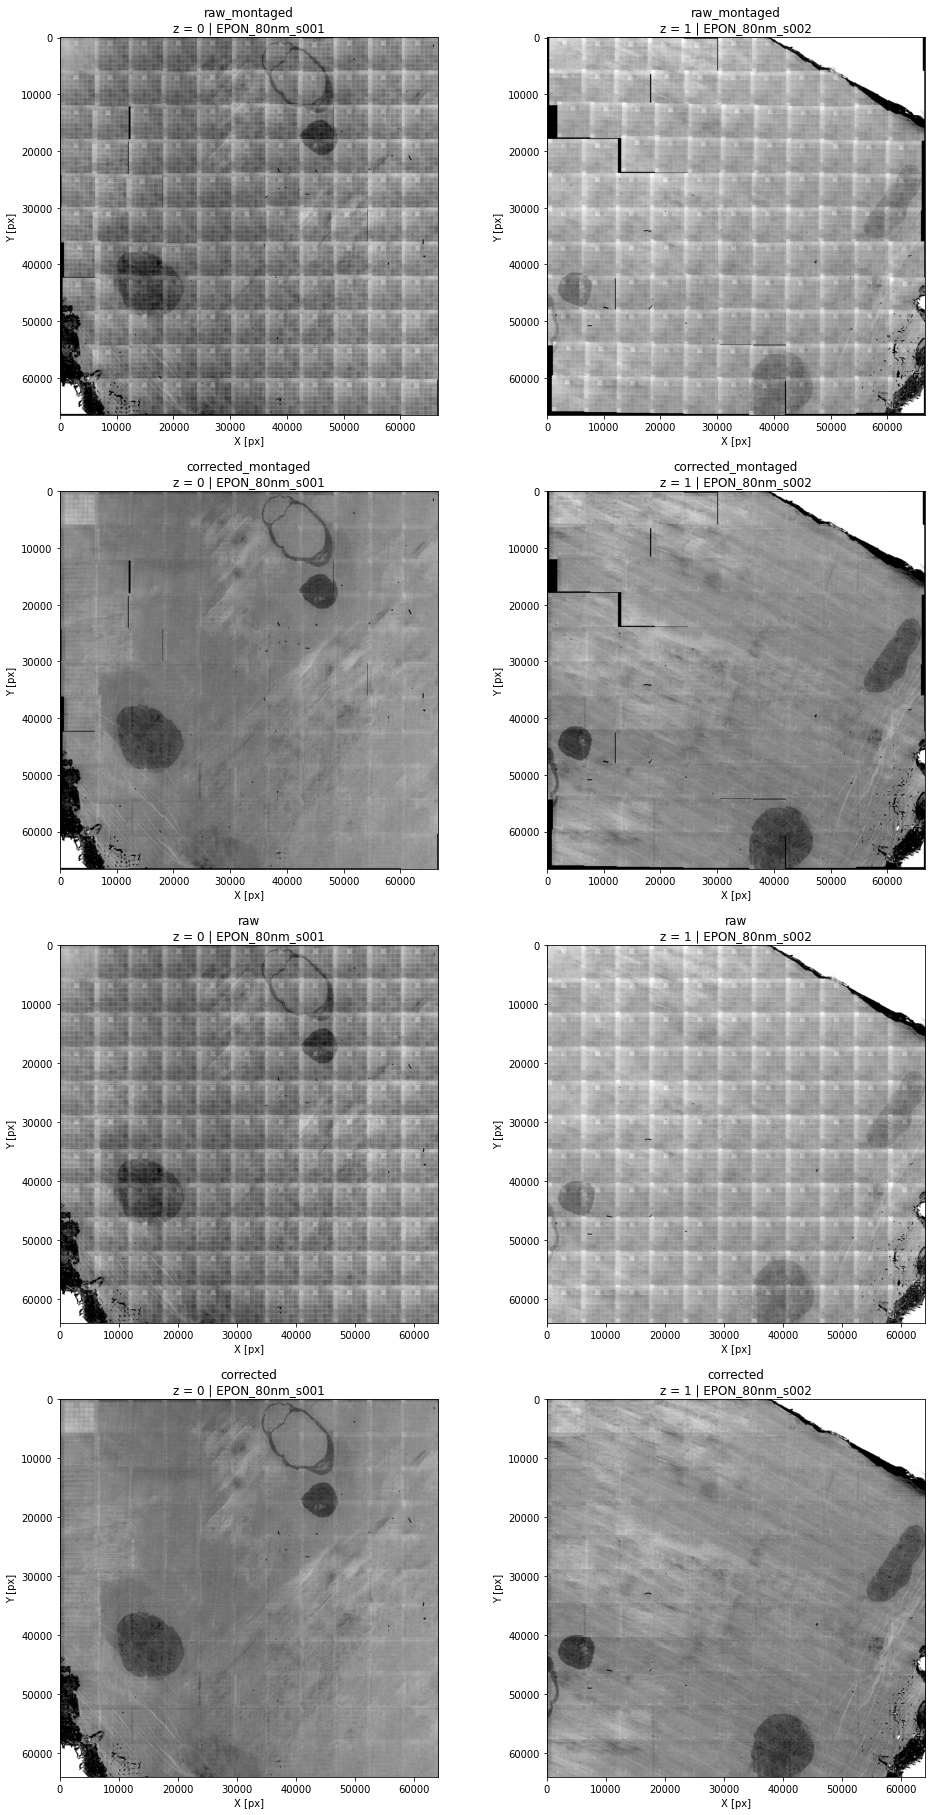

In [23]:
icatapi.plot_stacks(stacks_2_plot,
                    maxTileSpecsToRender=1000,
                    render=render)